In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

# Objective

This project focuses on forecasting passenger traffic for a specific flight route by analyzing historical monthly data of passengers boarding the flights. The goal is to help the airline company better plan and allocate resources, such as aircrafts and flight attendants, during peak periods. Various time series analysis techniques have been applied, and different models have been fitted to generate accurate forecasts.

# Data Loading

In [ ]:
data = pd.read_csv('airline-passenger-traffic.csv', header = None)
data.columns = ['Month','Passengers']
data['Month'] = pd.to_datetime(data['Month'], format='%Y-%m')
data = data.set_index('Month')
data.head(12)

,Passengers
Month,
1949-01-01,112.0
1949-02-01,118.0
1949-03-01,132.0
1949-04-01,129.0
1949-05-01,121.0
1949-06-01,135.0
1949-07-01,148.0
1949-08-01,148.0
1949-09-01,136.0


In [ ]:
data.shape

(144, 1)

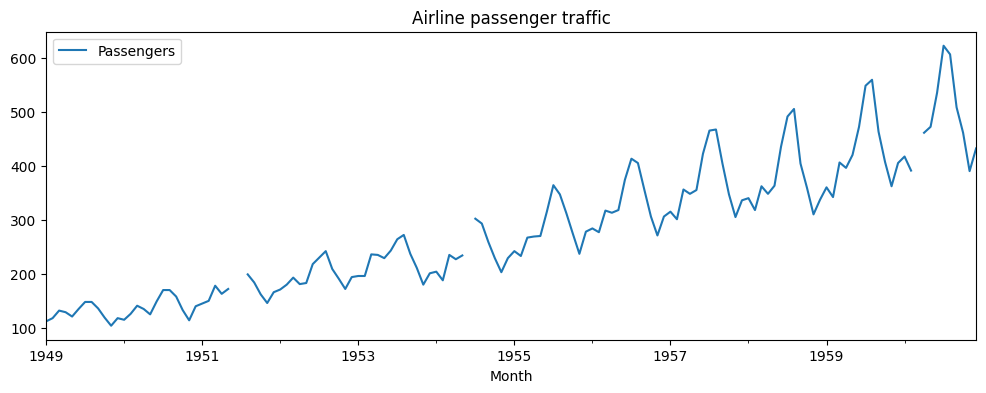

In [ ]:
data.plot(figsize=(12, 4))
plt.legend(loc='best')
plt.title('Airline passenger traffic')
plt.show(block=False)

The data is monthly data with increasing trend over the years.

# Handling Missing Values

Linear Interpolation for Missing Value Imputation

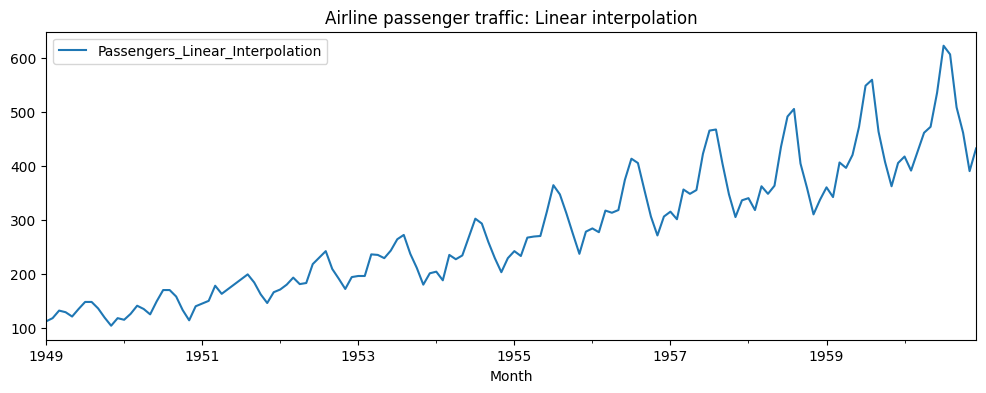

In [ ]:
data = data.assign(Passengers_Linear_Interpolation=data.Passengers.interpolate(method='linear'))
data[['Passengers_Linear_Interpolation']].plot(figsize=(12, 4))
plt.legend(loc='best')
plt.title('Airline passenger traffic: Linear interpolation')
plt.show(block=False)

In [ ]:
data['Passengers'] = data['Passengers_Linear_Interpolation']
data.drop(columns=['Passengers_Linear_Interpolation'],inplace=True)

# Time Series Decomposition

Additive Seasonal Decomposition

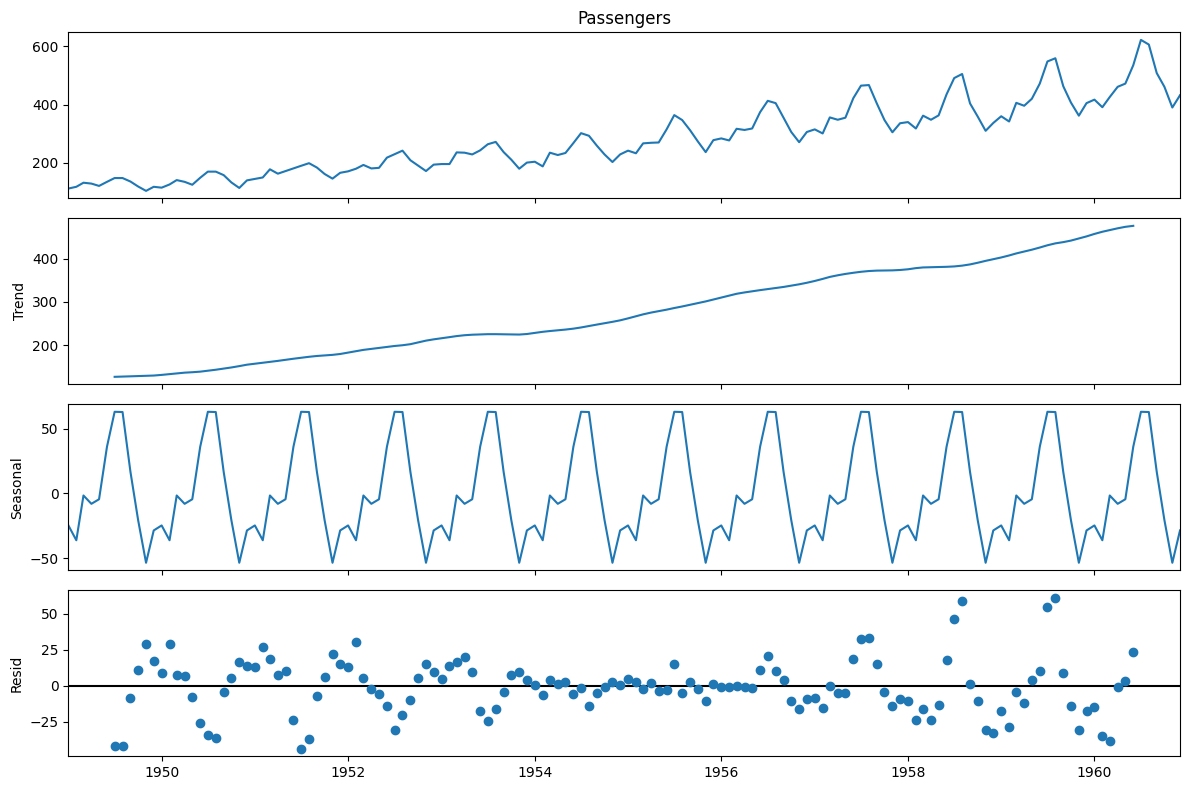

In [ ]:
from pylab import rcParams
import statsmodels.api as sm
rcParams['figure.figsize'] = 12, 8
decomposition = sm.tsa.seasonal_decompose(data.Passengers, model='additive') # additive seasonal index
fig = decomposition.plot()
plt.show()

The data is monthly data with increasing trend over the years.
There is a rising trend. There is also seasonality in data, which repeats over the year. Even after capturing seasonality, the residuals still show some amount of seasonality which cannot be explained. Let us check the multiplicative seasonality.

Multiplicative Seasonal Decomposition

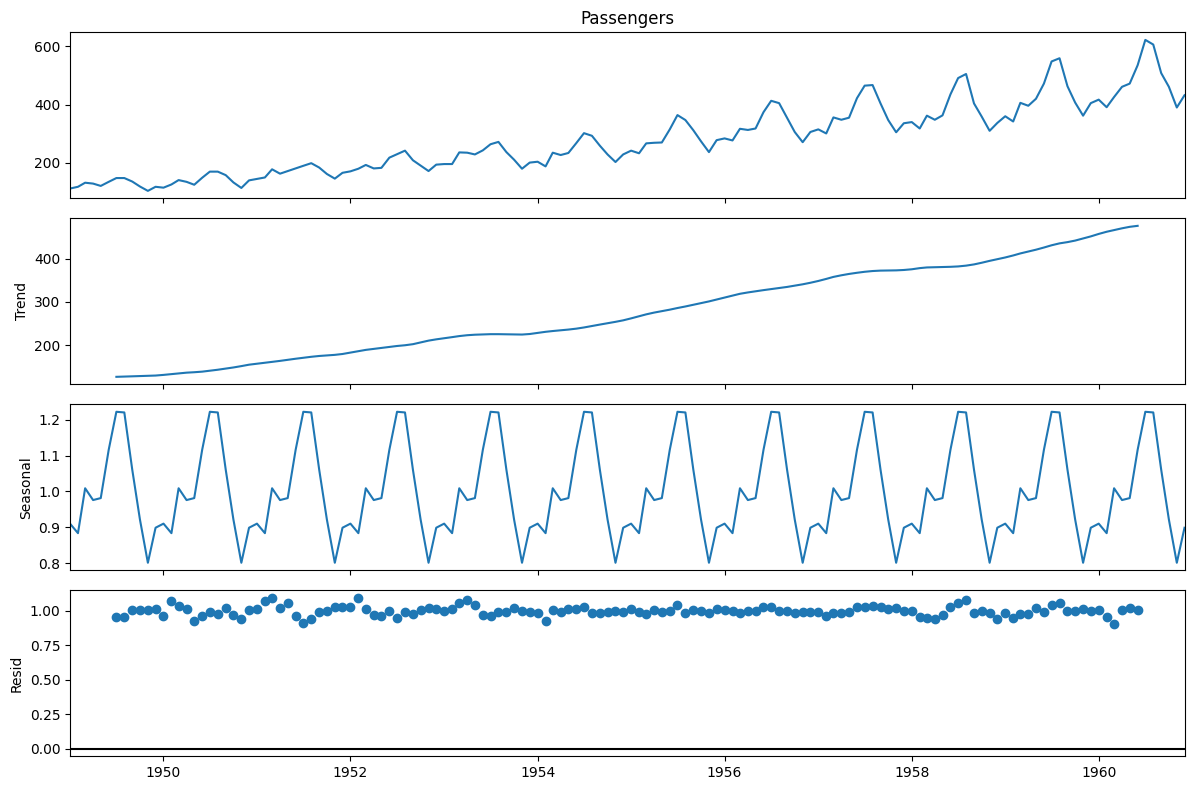

In [ ]:
decomposition = sm.tsa.seasonal_decompose(data.Passengers, model='multiplicative') # multiplicative seasonal index
fig = decomposition.plot()
plt.show()

Here also rising trend and seasonality shown. But here the residuals look random and dont follow any particular pattern.

# Splitting Time Series Data in Train and Test Sets

In [ ]:
train_len = 120
train = data[0:train_len]
test = data[train_len:]

# Stationarity Tests

Augmented Dickey-Fuller Test

In [ ]:
from statsmodels.tsa.stattools import adfuller
adf_test = adfuller(train['Passengers'])

print('ADF Statistic: %f' % adf_test[0])
print('Critical Values @ 0.05: %.2f' % adf_test[4]['5%'])
print('p-value: %f' % adf_test[1])

ADF Statistic: -0.601342
Critical Values @ 0.05: -2.89
p-value: 0.870678


p value greater than 0.05.

Kwiatkowski-Phillips-Schmidt-Shin Test

In [ ]:
from statsmodels.tsa.stattools import kpss
kpss_test = kpss(train['Passengers'])

print('KPSS Statistic: %f' % kpss_test[0])
print('Critical Values @ 0.05: %.2f' % kpss_test[3]['5%'])
print('p-value: %f' % kpss_test[1])

KPSS Statistic: 1.706343
Critical Values @ 0.05: 0.46
p-value: 0.010000


p value less than 0.05.

Inference: Both the tests indicate that the series is non stationary. Transformations need to be done to make the non stationary series stationary.

Boxcox transformation to make variance constant. Setting lambda as 0 indicating a simple log transformation.

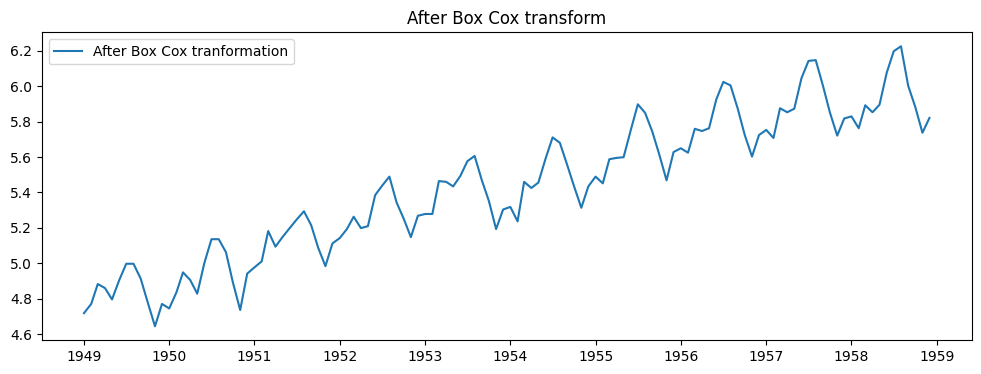

In [ ]:
from scipy.stats import boxcox

lmbda=0

train_boxcox = pd.Series(boxcox(train['Passengers'], lmbda=lmbda), index = train.index)

plt.figure(figsize=(12,4))
plt.plot(train_boxcox, label='After Box Cox tranformation')
plt.legend(loc='best')
plt.title('After Box Cox transform')
plt.show()

Now we notice that the fluctuations have become somewhat uniform. But the rising trend still exists.

First Order Differencing

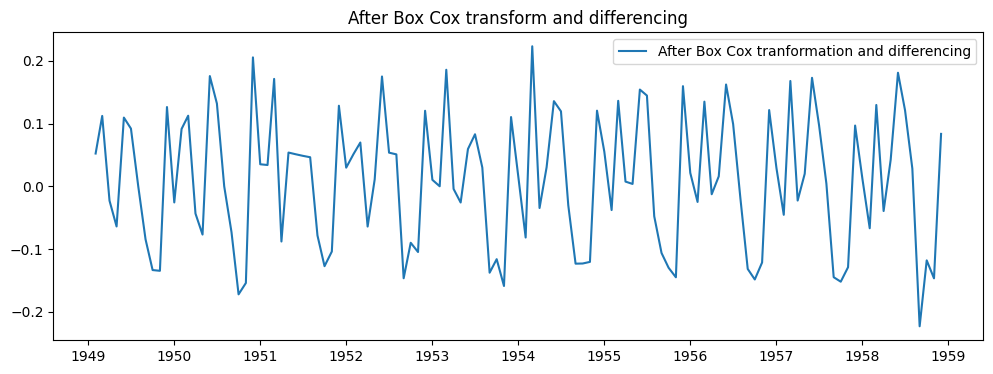

In [ ]:
train_boxcox_diff = pd.Series(train_boxcox - train_boxcox.shift(), train.index)
plt.figure(figsize=(12,4))
plt.plot(train_boxcox_diff, label='After Box Cox tranformation and differencing')
plt.legend(loc='best')
plt.title('After Box Cox transform and differencing')
plt.show()

In [ ]:
train_boxcox_diff=train_boxcox_diff.dropna()

Again stationarity test

In [ ]:
adf_test = adfuller(train_boxcox_diff)

print('ADF Statistic: %f' % adf_test[0])
print('Critical Values @ 0.05: %.2f' % adf_test[4]['5%'])
print('p-value: %f' % adf_test[1])

ADF Statistic: -2.629029
Critical Values @ 0.05: -2.89
p-value: 0.087145


In [ ]:
from statsmodels.tsa.stattools import kpss
kpss_test = kpss(train_boxcox_diff)

print('KPSS Statistic: %f' % kpss_test[0])
print('Critical Values @ 0.05: %.2f' % kpss_test[3]['5%'])
print('p-value: %f' % kpss_test[1])

KPSS Statistic: 0.029650
Critical Values @ 0.05: 0.46
p-value: 0.100000


Inference - For adfuller test, p value has decreased drastically from 0.8 to 0.08. It is not below 0.05 but still closer. For KPSS test, p value has increased to 0.1 from 0.01 and it is well above 0.05. So we can consider this stationary.

# ACF and PCF

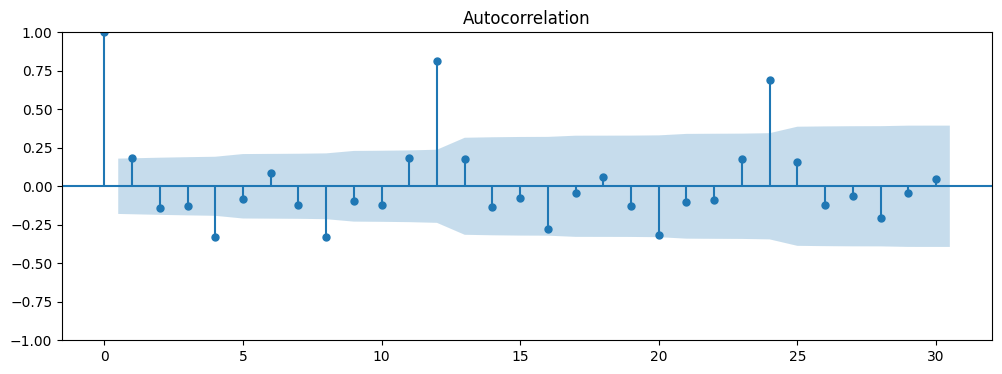

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf
plt.figure(figsize=(12,4))
plot_acf(train_boxcox_diff, ax=plt.gca(), lags = 30)
plt.show()

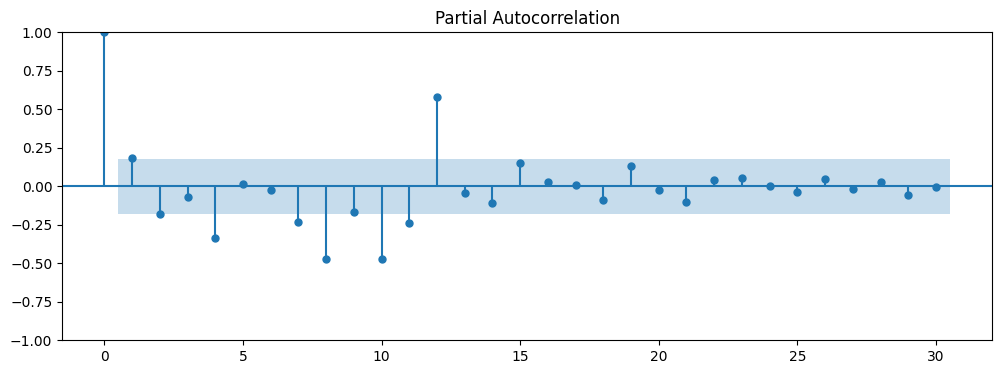

In [ ]:
from statsmodels.graphics.tsaplots import plot_pacf
plt.figure(figsize=(12,4))
plot_pacf(train_boxcox_diff, ax=plt.gca(), lags = 30)
plt.show()

The ACF and PACF shows high correlation at specific points. So there is seasonality in the data. Let us try to fit SARIMA (Seasonal Autoregressive Integrated Moving Average) model.

# SARIMA Model

In [ ]:
pip install pmdarima

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 20.3 MB/s eta 0:00:00


In [ ]:
from pmdarima import auto_arima

The data is monthly data with seasonality repeating yearly. So seasonal period m is 12.Since after first order differencing , data became stationary, we select d=1.

In [ ]:
stepwise_fit = auto_arima(train_boxcox, start_p = 0, start_q = 0,
                          max_p=1, max_q=1,
                          m = 12,
                          seasonal = True,
                          d = 1, D = 1, start_P=0, start_Q=0,
                          max_P=3, max_Q=3,
                          trace = True,
                          error_action ='ignore',
                          suppress_warnings = True,
                          stepwise = True)

# To print the summary
stepwise_fit.summary()

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=-356.096, Time=0.11 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=-380.632, Time=0.98 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=-386.621, Time=0.61 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=-361.922, Time=0.13 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=-384.837, Time=7.97 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=-384.837, Time=5.44 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=-382.837, Time=3.91 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=-382.884, Time=10.71 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=-380.656, Time=2.23 sec
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=-386.402, Time=5.28 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=-385.260, Time=0.39 sec
 ARIMA(0,1,1)(0,1,1)[12] intercept   : AIC=-384.794, Time=1.34 sec

Best model:  ARIMA(0,1,1)(0,1,1)[12]          
Total fit time: 39.168 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  120
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 12)   Log Likelihood                 196.311
Date:                            Wed, 29 Jan 2025   AIC                           -386.621
Time:                                    18:58:44   BIC                           -378.603
Sample:                                01-01-1949   HQIC                          -383.371
                                     - 12-01-1958                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.3092      0.090     -3.437      0.001      -0.486      -0.133
ma.S.L12      -0.5381      0.106     -5.071      0.000      -0.746      -0.330
sigma2         0.0014      0.000      7.784      0.000       0.001       0.002
===================================================================================
Ljung-Box (L1) (Q):                   0.09   Jarque-Bera (JB):                 0.56
Prob(Q):                              0.76   Prob(JB):                         0.76
Heteroskedasticity (H):               0.34   Skew:                             0.01
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.35
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
model = SARIMAX(train_boxcox, order=(0, 1, 1), seasonal_order=(0, 1, 1, 12))
model_fit = model.fit()
print(model_fit.params)

ma.L1      -0.309236
ma.S.L12   -0.538094
sigma2      0.001435
dtype: float64


# Forecasting On SARIMA

Applying BoxCox with lambda=0 on test data

In [ ]:
test_boxcox = pd.Series(boxcox(test['Passengers'], lmbda=lmbda), index = test.index)
test_boxcox_diff = pd.Series(test_boxcox - test_boxcox.shift(), test.index)
test_boxcox_diff=test_boxcox_diff.dropna()

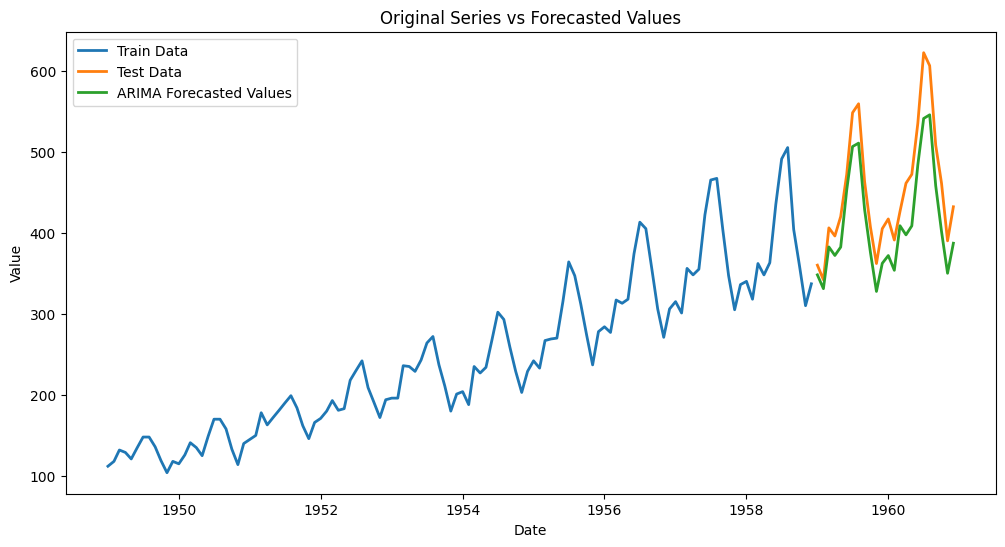

In [ ]:
forecast_diff1 = model_fit.predict(start=test_boxcox.index[0], end=test_boxcox.index[-1])
forecast_original = np.exp(forecast_diff1)

plt.figure(figsize=(12, 6))

# Plot the original training data
plt.plot(train.index, train, label='Train Data', linewidth=2)

# Plot the original test data (optional, can be used to show actual test values)
plt.plot(test.index, test, label='Test Data', linewidth=2)

# # Plot the forecasted values (forecast_original) on top of the original series
#plt.plot(forecast_original[len(train):], label='ARIMA Forecasted Values', linewidth=2)
plt.plot(forecast_original.index,forecast_original, label='ARIMA Forecasted Values', linewidth=2)


# Add labels and title
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Original Series vs Forecasted Values')
plt.legend()

# Show the plot
plt.show()


In [ ]:
assert len(forecast_original) == len(test)
assert all(forecast_original.index == test.index)

rmse = np.sqrt(mean_squared_error(test['Passengers'], forecast_original)).round(2)
mape = np.round(np.mean(np.abs((test['Passengers'] - forecast_original) / test['Passengers'])) * 100, 2)
print(f"RMSE: {rmse}")
print(f"MAPE: {mape}%")

RMSE: 44.16
MAPE: 8.78%


# SARIMAX Model

The data below represents promotional events organized by the airline at various times throughout the year to attract passengers. These promotional events serve as exogenous variables that impact the number of passengers boarding flights during specific periods. To analyze this relationship, SARIMAX (Seasonal AutoRegressive Integrated Moving Average with eXogenous regressors) is utilized.

In [ ]:
promo = pd.read_csv('promotion.csv', header = None)
promo.columns = ['Month','Event']
promo['Month'] = pd.to_datetime(promo['Month'], format='%Y-%m')
promo = promo.set_index('Month')
promo

,Event
Month,
1949-01-01,0
1949-02-01,0
1949-03-01,0
1949-04-01,0
1949-05-01,0
...,...
1960-08-01,1
1960-09-01,1
1960-10-01,1


In [ ]:
promo_train = promo[:train_len]
promo_test = promo[train_len:]

In [ ]:
model = SARIMAX(train_boxcox, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12), exog=promo_train)
model_fit = model.fit()
print(model_fit.params)

Event       0.034356
ar.L1       0.481182
ma.L1      -0.743378
ar.S.L12   -0.064583
ma.S.L12   -0.557249
sigma2      0.001334
dtype: float64


# Forecasting on SARIMAX

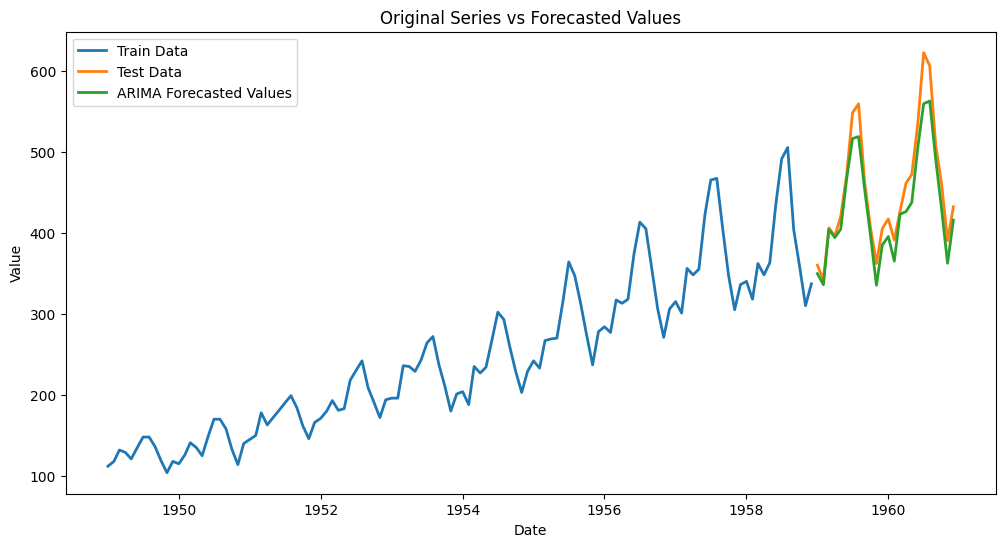

In [ ]:
forecast_diff = model_fit.predict(start=test_boxcox.index[0], end=test_boxcox.index[-1], exog=promo_test)
forecast_original = np.exp(forecast_diff)

plt.figure(figsize=(12, 6))

# Plot the original training data
plt.plot(train.index, train, label='Train Data', linewidth=2)

# Plot the original test data (optional, can be used to show actual test values)
plt.plot(test.index, test, label='Test Data', linewidth=2)

# # Plot the forecasted values (forecast_original) on top of the original series
plt.plot(forecast_original.index,forecast_original, label='ARIMA Forecasted Values', linewidth=2)


# Add labels and title
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Original Series vs Forecasted Values')
plt.legend()

# Show the plot
plt.show()


In [ ]:
assert len(forecast_original) == len(test)
assert all(forecast_original.index == test.index)

rmse = np.sqrt(mean_squared_error(test['Passengers'], forecast_original)).round(2)
mape = np.round(np.mean(np.abs((test['Passengers'] - forecast_original) / test['Passengers'])) * 100, 2)
print(f"RMSE: {rmse}")
print(f"MAPE: {mape}%")

RMSE: 26.61
MAPE: 4.65%


# Conclusion

In conclusion, the time series analysis successfully provided accurate passenger traffic forecasts for the airline's specific route. The SARIMAX model, which included promotional events as an exogenous variable, significantly improved forecast accuracy, resulting in lower RMSE and MAPE values compared to the SARIMA model. These findings will help the airline optimize resource allocation during peak periods.